### Se importan las librerías necesarias

In [263]:
import numpy as np
from scipy.integrate import simps
from numpy import trapz
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.metrics import auc
from scipy.optimize import curve_fit
%matplotlib inline

In [387]:
# Esta función regresa la intensidad total del haz y el coeficiente de atenuación
# del medio.


def intensidad_y_coeficiente(archivo_tsv, pixeles_por_cm):
    
    # Se lee el archivo data que debe ser un .tsv (tab seprated values) y se le da
    # el formato adecuado para su análisis
    txt = np.genfromtxt(f"../data/imagenes_texto/{archivo_tsv}", delimiter="\t")
    m,n = txt.shape
    R,C = np.mgrid[:m,:n]
    out = np.column_stack((C.ravel(),R.ravel(), txt.ravel()))
    df = pd.DataFrame(out, columns = ["x",'y','z'])
    df = df.astype(int)
    df["x_cm"] = df["x"] / pixeles_por_cm
    df["y_cm"] = df["y"] / pixeles_por_cm
    df["z"] = df["z"] / 255
    
    print("\n------------------------------------------------\n")
    print(f'El archivo arojó un dataframe de {df.shape[0]} registros y {df.shape[1]} columnas')
    print("\n------------------------------------------------\n")
   
    # se crea un diccionario auxiliar donde almacenar cada uno de los slices 
    # de la imagen.
    aux_dicc = {}
    y_max = max(df["y"])
    df_split = df.copy()
    for i in range(y_max + 1):
        aux_dicc[f"df_{i}"] = df_split[df_split["y"] == i]
    
    
    # Se obtiene la intensidad para cada slice y se guarda en la lista intensidades_slice
    intensidades_slice = [auc(aux_dicc[f"df_{i}"]["x_cm"], aux_dicc[f"df_{i}"]["z"]) for i in range(y_max + 1)]
    df_nuevo = pd.DataFrame(intensidades_slice, columns=["intensidad"])
    df_nuevo["y_cm"] = pd.DataFrame(range(y_max + 1), columns=["y_cm"])
    df_nuevo["y_cm"] = df_nuevo["y_cm"] / pixeles_por_cm
    intervalo = df_nuevo["y_cm"].diff().mean()
    df_nuevo["atenuacion"] = 1 / intervalo * np.log(df_nuevo["intensidad"] / df_nuevo["intensidad"].shift(1))
    # df_nuevo["intensidad"] = df_nuevo["intensidad"].iloc[:-1]
    
    # Se mustra el encabezado del dataframe con los valores en el eje "y" y sus respectivas
    # intensidades
    print("\n----------------Intensidades----------------------\n")
    print(f"{df_nuevo.head()}")
    print("\n------------------------------------------------\n")
    
    # Se resuelve la integral por el método del trapezoide
    intensidad_total = round(auc(df_nuevo["y_cm"], df_nuevo["intensidad"]), 3)
    atenuacion = round(df_nuevo["atenuacion"].mean(), 3)
    atenuacion_desv_est = round(df_nuevo["atenuacion"].std(), 3)
    
    print(f"La intesidad total del haz en la región es: {intensidad_total}\n")
    print(f"El coeficiente de atenuación es: {atenuacion} +/- {atenuacion_desv_est}")
    print(f'\t\t\tError porcentual: {round(atenuacion_desv_est / atenuacion * 100, 3)}%')
    
    
    print("\n------------------------------------------------\n")
    
    print("------------- Gráfica de los puntos ---------------\n")
    
    # Se muestra la gráfica de los puntos de las intensidades
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(df["y_cm"], df["x_cm"], df["z"], c=df["z"], cmap='Greens')
    ax.set_title("Intensidad del Haz")
    ax.set_xlabel("Eje y [cm]")
    ax.set_ylabel("Eje x [cm]")
    ax.set_zlabel("Intensidad")
    
    return df_nuevo
    


In [388]:
def ajuste(data_frame):
    x = data_frame["y_cm"]
    y = data_frame["intensidad"].fillna(0)
    
    popt, _ = curve_fit(recta, x, y, maxfev=4000)
    a, b = popt

    print(f'a = {round(a, 3)} +/- {round(np.sqrt(np.diag(_))[0], 3)}\nb = {round(b, 3)} +/- {round(np.sqrt(np.diag(_))[1], 3)}')
    
    plt.scatter(x, y, label="Datos\nExperimentales")
    
    # Se crea un array con el dominio de x
    x_line = np.arange(min(x), max(x), 0.01)

    # Se evalua la función en el dominio x_line
    y_line = recta(x_line, a, b)

    # Se grafica el ajuste y_line
    plt.plot(x_line, y_line, '--', color='red', label="Ajuste:\nIr=ax+b$")
    plt.xlabel("Posición [cm]")
    plt.ylabel("Intensidad Lumínica Relativa")
    plt.title(f"Ajuste lineal de la intensidad lumínica relativa")
    plt.legend()
    plt.grid()

In [389]:
def recta(x, a, b):
    return a * x + b

##### Medio con concentración grenetina/agua 3:1


------------------------------------------------

El archivo arojó un dataframe de 30814 registros y 5 columnas

------------------------------------------------


----------------Intensidades----------------------

   intensidad      y_cm  atenuacion
0    0.083140  0.000000         NaN
1    0.083650  0.015285    0.399704
2    0.084219  0.030571    0.443857
3    0.085268  0.045856    0.809832
4    0.086407  0.061142    0.868042

------------------------------------------------

La intesidad total del haz en la región es: 1.649

El coeficiente de atenuación es: 0.18 +/- 0.716
			Error porcentual: 397.778%

------------------------------------------------

------------- Gráfica de los puntos ---------------



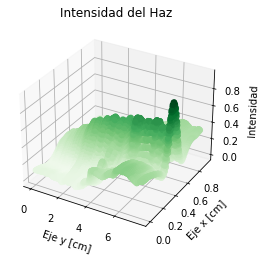

In [390]:
gg_1 = intensidad_y_coeficiente("long_31_recortada.tsv", 65.422)

Text(0.5, 1.0, 'Atenuacion')

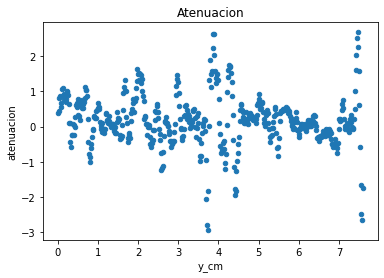

In [391]:
gg_1.plot.scatter(x="y_cm", y="atenuacion")
plt.title("Atenuacion")

a = 0.034 +/- 0.0
b = 0.087 +/- 0.002


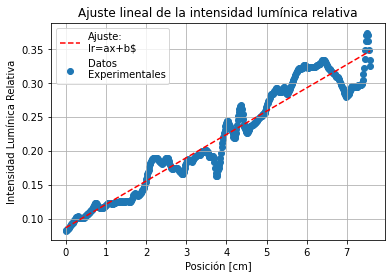

In [392]:
ajuste(gg_1)

##### Medio con concentración grenetina/agua 1:1


------------------------------------------------

El archivo arojó un dataframe de 227622 registros y 5 columnas

------------------------------------------------


----------------Intensidades----------------------

   intensidad      y_cm  atenuacion
0    0.116120  0.000000         NaN
1    0.116546  0.007237    0.505650
2    0.116915  0.014474    0.436738
3    0.117127  0.021711    0.251338
4    0.118688  0.028948    1.829305

------------------------------------------------

La intesidad total del haz en la región es: 2.067

El coeficiente de atenuación es: 0.057 +/- 0.733
			Error porcentual: 1285.965%

------------------------------------------------

------------- Gráfica de los puntos ---------------



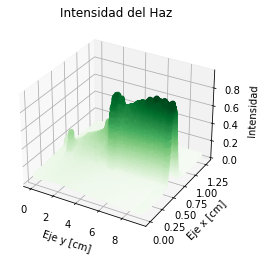

In [393]:
gg_2 = intensidad_y_coeficiente("long_11_recortada.tsv", 138.177)

Text(0.5, 1.0, 'Atenuacion')

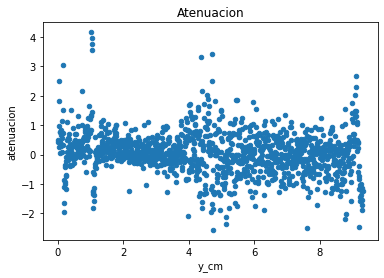

In [394]:
gg_2.plot.scatter(x="y_cm", y="atenuacion")
plt.title("Atenuacion")

a = 0.009 +/- 0.0
b = 0.181 +/- 0.002


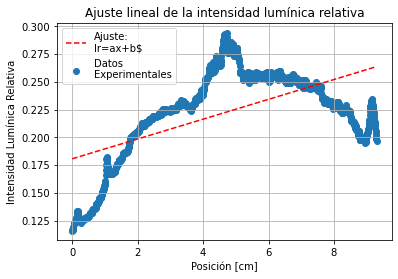

In [395]:
ajuste(gg_2)

##### Medio con concentración grenetina/agua 6:1




------------------------------------------------

El archivo arojó un dataframe de 38927 registros y 5 columnas

------------------------------------------------


----------------Intensidades----------------------

   intensidad      y_cm  atenuacion
0    0.234136  0.000000         NaN
1    0.234015  0.015492   -0.033507
2    0.233711  0.030983   -0.083843
3    0.233589  0.046475   -0.033568
4    0.233984  0.061967    0.109032

------------------------------------------------

La intesidad total del haz en la región es: 2.447

El coeficiente de atenuación es: 0.013 +/- 0.262
			Error porcentual: 2015.385%

------------------------------------------------

------------- Gráfica de los puntos ---------------



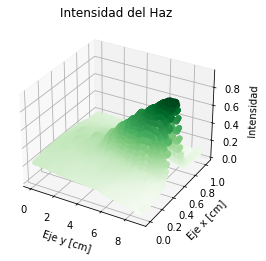

In [396]:
gg_3 = intensidad_y_coeficiente("long_61_recortada.tsv", 64.551)

Text(0.5, 1.0, 'Atenuacion')

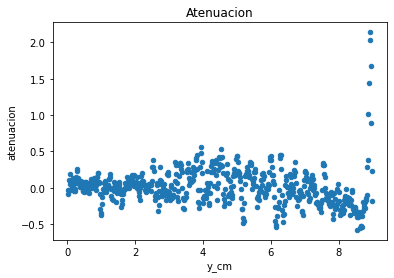

In [397]:
gg_3.plot.scatter(x="y_cm", y="atenuacion")
plt.title("Atenuacion")

a = 0.007 +/- 0.0
b = 0.24 +/- 0.002


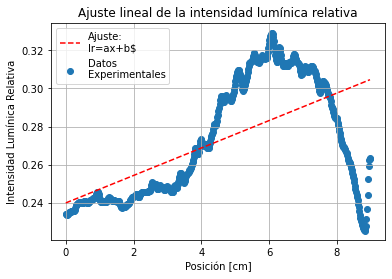

In [398]:
ajuste(gg_3)